# Бинарная классификация с применением нейронной сети с одним скрытым слоем

В данной лабораторной работе рассмотрим процесс создание нейронной сети с одним скрытым слоем. Сравните данную модель с уже изученной Вами ранее- логистической регрессией.

**В результате выполнения данной лабораторной Вы:**
- Создадите нейронную сеть с одним скрытым слоем для бинарной классификации
- Используете нелинейную функцию активации нейронов, например тангенциальную
- Рассчитаете ошибку при помощи перекресной энтропии
- Примените алгоритм обратного распространения ошибки


## 1 - Библиотеки ##

Вначале импортируем следующие необходимые для выполнения лабораторной работы библиотеки:
- [numpy](https://www.numpy.org/) - одна из основных библиотек для работы с данными при использовании языка Python.
- [sklearn](http://scikit-learn.org/stable/) предоставляет простые и эффективные модели для анализа данных
- [matplotlib](http://matplotlib.org) - это библиотека для создания графиков.
- Модуль testCases содержит набор тестовых примеров и позволяет оценить корректность реализованных Вами функций.
- Модуль planar_utils содержит множество функций используемых в данной лабораторной работе.

In [365]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # не меняйте это значение для автоматической проверки правильности выполнения

## 2 - Набор данных ##

Для начала загрузим данные, которые необходимо анализировать. Следующий код загружает набор данных "Полярная роза" (известная математическая кривая, похожая на цветок с лепестками). Загрузим координаты точек `X` и `Y`.

In [366]:
X, Y = load_planar_dataset()

Визуализируем данные с помощью библиотеки matplotlib. Точки представляют собой "цветок" и имеют красные маркеры (y=0) и синие (y=1). Необходимо создать модель классификации точек по цвету.

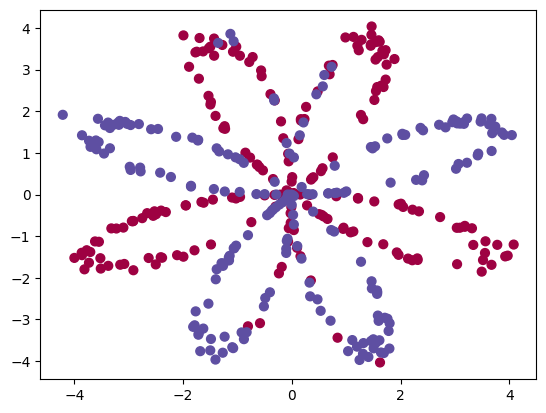

In [367]:
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral)

In [368]:
print(type(X))
print(X.size)
print(X.shape)

print(type(Y))
print(Y.size)
print(Y.shape)

<class 'numpy.ndarray'>
800
(2, 400)
<class 'numpy.ndarray'>
400
(1, 400)


 Имеем:
    - numpy-массив (матрица) X содержащая переменные (x1, x2)
    - numpy-массив (вектор) Y содержащий метку класса (красный:0, синий:1).


**Задание**: Каков размер вашей обучающей выборки? А также,какова форма numpy-массивов `X` и `Y`?


Размер обучающей выборки - 400 семплов<br>
X : (2, 400) <br>
Y : (1, 400)

In [369]:
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]
print ('Форма X: ' + str(shape_X))
print ('Форма Y: ' + str(shape_Y))
print ('m = ',m)

Форма X: (2, 400)
Форма Y: (1, 400)
m =  400


In [370]:
assert shape_X == (2,400)
assert shape_Y == (1,400)
assert m == 400

## 3 - Логистическая регрессия

Перед созданием нейронной сети рассмотрим применимость логистической регрессии в данном случае. Для этого Вы можете использовать встроенные функции библиотеки sklearn. Запустите следующий код для обучения классификатора на основе логистической регрессии по представленным данным.

In [371]:
Y1 = np.ravel(Y)
print(Y1.shape)
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y1.T)

(400,)


LogisticRegressionCV()

Теперь вы можете визуализировать границу раздела классов для данной модели. Запустите код, предложенный ниже.

Точность логистической регрессии:  47.0 % (процент правильно классифицированных точек)


/var/folders/5x/5z67klg92k997tvr4jjj1tt80000gn/T/ipykernel_70276/271613231.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Точность логистической регрессии: ', float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100),


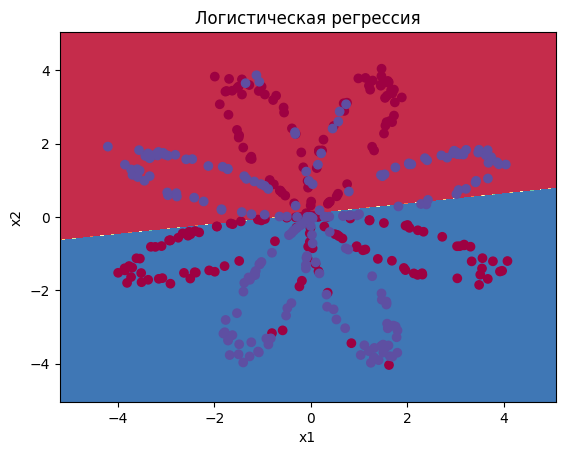

In [372]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Логистическая регрессия")

LR_predictions = clf.predict(X.T)
print ('Точность логистической регрессии: ', float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100),
       '% (процент правильно классифицированных точек)')

**Задание**: Объясните низкий процент точности при применении логистической регреессии к данной задаче.

Заметно и из границы раздела, и из вида логистической регрессии (определяет разделяющую гиперплоскость), что она спообна построить только лишь <br>
линейный раздел, что неприменимо в данной задаче, поскольку нельзя разграничить два класса лишь одной прямой - отсюда и 50% точности

## 4 - Нейронная сеть

Алгоритм логистичской регрессии показал слабую классификацию на наборе данных "Полярная роза". Далее Вам предстоить использовать нейронную сеть с одним скрытым слоем для улучшения качества класссификации.

**Архитектура используемой сети с одним скрытым слоем**:
<img src="images/classification.png" style="width:600px;">

**Алгоритм обучения нейронной сети**:

Для экземпляра данных $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{, если } a^{[2](i)} > 0.5 \\ 0 & \mbox{, иначе } \end{cases}\tag{5}$$

Используя все обучающие примеры, в качестве функции ошибки ИНС будем оценивать функционал стоимости $J$ как:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Важно**: Используем алогоритм построения искусственной нейронной сети:
    1. Определить архитектуру нейросетевой модели ( количество входов,  число скрытых слоев, размеры слоев и другие).
    2. Инициализировать параметры модели (веса, смещения, граденты, оценку функционала и другие)
    3. На каждой итерации обучения:
        - Прямое распространение сигнала по сети (предъявление очередного
        набора из обучающей выборки на вход нейронной сети)
        - Вычисление выходного сигнала сети и функции ошибки
        - Обратное распространение ошибки и определение величин ошибок нейронов
        - Обновление весов сети (методом градиентного спуска)

В начале следует реализовать основные функции алгоритма, а затем использовать их в правильном порядке в главной функции модели `nn_model()`. После реализации `nn_model()` и обучения нейронной сети Вы получите классификатор и сможете его применить на "новых" для сети данных (которых не было в обучающем наборе).

### 4.1 - Определение архитектуры нейронной сети ####

**Задание**: Определите три переменных в соотвествии с изображением:
    - n_x: размер входного слоя
    - n_h: размер скрытого слоя
    - n_y: размер выходного слоя

In [373]:
def layer_sizes(X, Y):
    # YOUR CODE HERE
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

In [374]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("Размер входного слоя: n_x = " + str(n_x))
print("Размер скрытого слоя: n_h = " + str(n_h))
print("Размер выходного слоя: n_y = " + str(n_y))

assert n_x == 5
assert n_h == 4
assert n_y == 2

Размер входного слоя: n_x = 5
Размер скрытого слоя: n_h = 4
Размер выходного слоя: n_y = 2


### 4.2 - Инициализация параметров модели ####

**Задание**: Реализуйте функцию `initialize_parameters()`, которая инициализирует веса W нейронов вещественными случайными числами и смещения b нулями.

In [375]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)

    W1 = np.random.randn(n_h, n_x) 
    W2 = np.random.randn(n_y, n_h)   
    b1 = np.zeros((n_h, 1))
    b2 = np.zeros((n_y, 1))

    # проверки формы
    assert W1.shape == (n_h, n_x)
    assert b1.shape == (n_h, 1)
    assert W2.shape == (n_y, n_h)
    assert b2.shape == (n_y, 1)

    return {"W1": W1, "b1": b1,
            "W2": W2, "b2": b2}


### 4.3 - Цикл обучения ####

**Задание**: Реализуйте функцию прямого распространения сигнала по сети `forward_propagation()`.

**Указания**:
- Следуйте математическому описанию работы нейрона.
- Используйте функцию `sigmoid()` из пакета planar_utils и тангенциальную функцию np.tanh().
- Реализуйте прямое распространение обучающей выборки по сети, вычислив векторы выходных значений и активаций нейронов $Z^{[1]}, A^{[1]}, Z^{[2]}$ и $A^{[2]}$.
- Значения для вышисления ошибок при обратном распространении ошибок сохраняются в "`cache`".

In [376]:
def forward_propagation(X, parameters):
    W1, b1 = parameters['W1'],parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']

    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [377]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

assert(A2.shape == (1, X_assess.shape[1]))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


После вычисления вектора $A^{[2]}$ выходных значений нейрона выходного слоя для каждого экземпляра обучающей выборки $a^{[2](i)}$, необходимо вычислить функционал стоимости (ошибки) на основе перекрестной энтропии:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Задание**: Реализуйте функцию `compute_cost()` для расчета функционала ошибки $J$ с помощью.

In [378]:
def compute_cost(A2, Y, parameters):
    m = Y.shape[1]

    # YOUR CODE HERE
    cost = - (1/m) * np.sum( Y* np.log(A2) + (1-Y)* np.log(1-A2))

    return cost

In [379]:
A2, Y_assess, parameters = compute_cost_test_case()

cost = compute_cost(A2, Y_assess, parameters)
print("cost = " + str(cost))

assert(isinstance(cost, float))

cost = 0.6930587610394646


**Задание**: Используя сохраненные значения при прямом проходе, реализуйте обратное распространение ошибки `backward_propagation()`.

**Указания**:
Минимизация методом градиентного спуска обеспечивает подстройку весовых коэффициентов следующим образом:  

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Совет:
    - Для вычисления dZ1 необходимо вычислить $g^{[1]'}(Z^{[1]})$. Т.к. $g^{[1]}(.)$ - тангенциальная функция активации, если $a = g^{[1]}(z)$, то $g^{[1]'}(z) = 1-a^2$. Так вы можете вычислить
    $g^{[1]'}(Z^{[1]})$ используя `(1 - np.power(A1, 2))`.

In [380]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]

    # YOUR CODE HERE
    W1, W2 = parameters['W1'], parameters['W2']
    A1, A2 = cache['A1'], cache['A2']

    
    dZ2= A2-Y
    dZ1 = np.dot(W2.T,dZ2) * (1-np.power(A1,2))


    dW1 = (1/m) * np.dot(dZ1,X.T)
    dW2 = (1/m) * np.dot(dZ2,A1.T)

    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims=True)
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [381]:
A2.shape

(1, 3)

In [382]:
A2, cache = forward_propagation(X_assess, parameters)

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
grads

{'dW1': array([[ 0.00487281,  0.00064363],
        [ 0.00417893,  0.00055596],
        [-0.00253899, -0.00033412],
        [-0.01055324, -0.00139104]]),
 'db1': array([[-0.00176445],
        [-0.00151796],
        [ 0.00091929],
        [ 0.00382131]]),
 'dW2': array([[ 0.0019538 ,  0.00883346,  0.00877086, -0.00155899]]),
 'db2': array([[0.16677621]])}

**Проверочные значения**:



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td>
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td>
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td>
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[-0.16655712]] </td>
  </tr>
  
</table>  

**Задание**: Реализуйте коррекцию весов, используя (dW1, db1, dW2, db2) для обновления (W1, b1, W2, b2).

**Правило обновления весов градиентного спуска**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$, где $\alpha$ - это параметр скорости обучения, а $\theta$ представляет обновляемый параметр.

Алгоритм градиентного спуска с оптимальной скорость обучения сходится, а с плохо подобранной - расходится.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [383]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    # YOUR CODE HERE
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]

    W1 -= learning_rate * grads["dW1"]
    b1 -= learning_rate * grads["db1"]
    W2 -= learning_rate * grads["dW2"]
    b2 -= learning_rate * grads["db2"]

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [384]:
update_parameters(parameters, grads)

{'W1': array([[-0.01001495, -0.00133502],
        [-0.02637668,  0.01573556],
        [-0.01488758, -0.00801652],
        [ 0.01769269, -0.01078364]]),
 'b1': array([[ 0.00211734],
        [ 0.00182155],
        [-0.00110315],
        [-0.00458557]]),
 'W2': array([[-0.01292408, -0.01969023, -0.00501049,  0.02479286]]),
 'b2': array([[-0.20013146]])}

**Ожидаемые значения**:


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td>
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td>
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td>
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td>
  </tr>
  
</table>  

### 4.4 - Построение модели нейронной сети nn_model() ####

**Задание**: Постройте нейросетевую модель в функции `nn_model()`, используя реализованные функции.

In [385]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x, n_h, n_y)
    # YOUR CODE HERE
    

    # Loop (gradient descent)

    for i in range(0, num_iterations):
        
        A2, cache  = forward_propagation(X, parameters)
        cost       = compute_cost(A2, Y, parameters)
        grads      = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Значение ошибки после %i итерации: %f" %(i, cost))

    return parameters

In [386]:
nn_model(X,Y,n_h)

{'W1': array([[  0.18175896,  -8.28127525],
        [ -3.38093509,   9.66545879],
        [-10.55263504, -12.24079622],
        [ 10.70741327, -12.91563975]]),
 'b1': array([[-0.05979079],
        [ 0.32961249],
        [-0.0857209 ],
        [ 0.0991492 ]]),
 'W2': array([[-12.38223885,  -2.97525777,   6.25178742,   4.94573102]]),
 'b2': array([[-0.04522492]])}

**Ожидаемые значения**:

<table style="width:90%">

<tr>
    <td>
        **cost after iteration 0**
    </td>
    <td>
        0.692739
    </td>
</tr>

<tr>
    <td>
        <center> $\vdots$ </center>
    </td>
    <td>
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>**W1**</td>
    <td> [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]</td>
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]] </td>
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-2.45566237 -3.27042274  2.00784958  3.36773273]] </td>
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.20459656]] </td>
  </tr>
  
</table>  

### 4.5 Прогноз

**Задание**: Реализуйте функцию predict() для прогноза модели.
Используйте прямое распространение сигнала по сети.


In [387]:
def predict(parameters, X):
    """
    Используя параметры обученной модели, предскажем класс для каждого примера в X

    Аргументы:
    parameters -- Словарь python хранит в себе параметры вашей модели
    X -- входные данные размерности (n_x, m)

    Выход функции
    predictions -- Вектор с прогнозом вашей модели (красный: 0 / синий: 1)
    """


    A2, _ = forward_propagation(X, parameters)
    predictions=(A2 > 0.5).astype(int)
    # YOUR CODE HERE
    return predictions

In [388]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

assert round(np.mean(predictions),3)==0.667

predictions mean = 0.6666666666666666


Давайте запустим модель и посмотрим как она справится со всем набором данных. Запустите следующий код и протестируйте свою нейронную сеть с одим скрытым слоем, содержащим $n_h$ нейронов.

Значение ошибки после 0 итерации: 1.127380
Значение ошибки после 1000 итерации: 0.288553
Значение ошибки после 2000 итерации: 0.276386
Значение ошибки после 3000 итерации: 0.268077
Значение ошибки после 4000 итерации: 0.263069
Значение ошибки после 5000 итерации: 0.259617
Значение ошибки после 6000 итерации: 0.257070
Значение ошибки после 7000 итерации: 0.255105
Значение ошибки после 8000 итерации: 0.253534
Значение ошибки после 9000 итерации: 0.252245


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

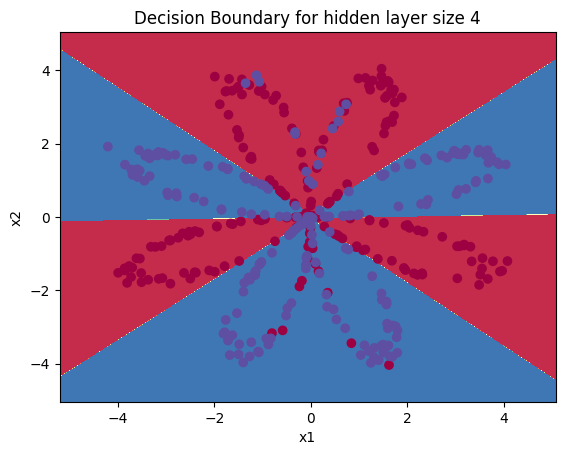

In [389]:
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

**Ожидаемый выход**:

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.218607 </td>
  </tr>
  
</table>


In [390]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 91%


/var/folders/5x/5z67klg92k997tvr4jjj1tt80000gn/T/ipykernel_70276/4061831946.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')


**Expected Output**:

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td>
  </tr>
</table>

Точность значительно увеличилась по сравнению с логистической регрессией, давайте теперь попробуем различные варианты реализации скрытого слоя.

### 4.6 - Изменение количество нейронов на скрытом слое ###

Запустите следующий код. Проанализируйте влияние размерности скрытого слоя на результат классификации.

/var/folders/5x/5z67klg92k997tvr4jjj1tt80000gn/T/ipykernel_70276/447635059.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Точность для 1 скрытого слоя: 61.5 %
Точность для 2 скрытого слоя: 70.5 %
Точность для 3 скрытого слоя: 66.25 %
Точность для 4 скрытого слоя: 90.75 %
Точность для 5 скрытого слоя: 90.5 %
Точность для 20 скрытого слоя: 92.0 %
Точность для 50 скрытого слоя: 90.75 %


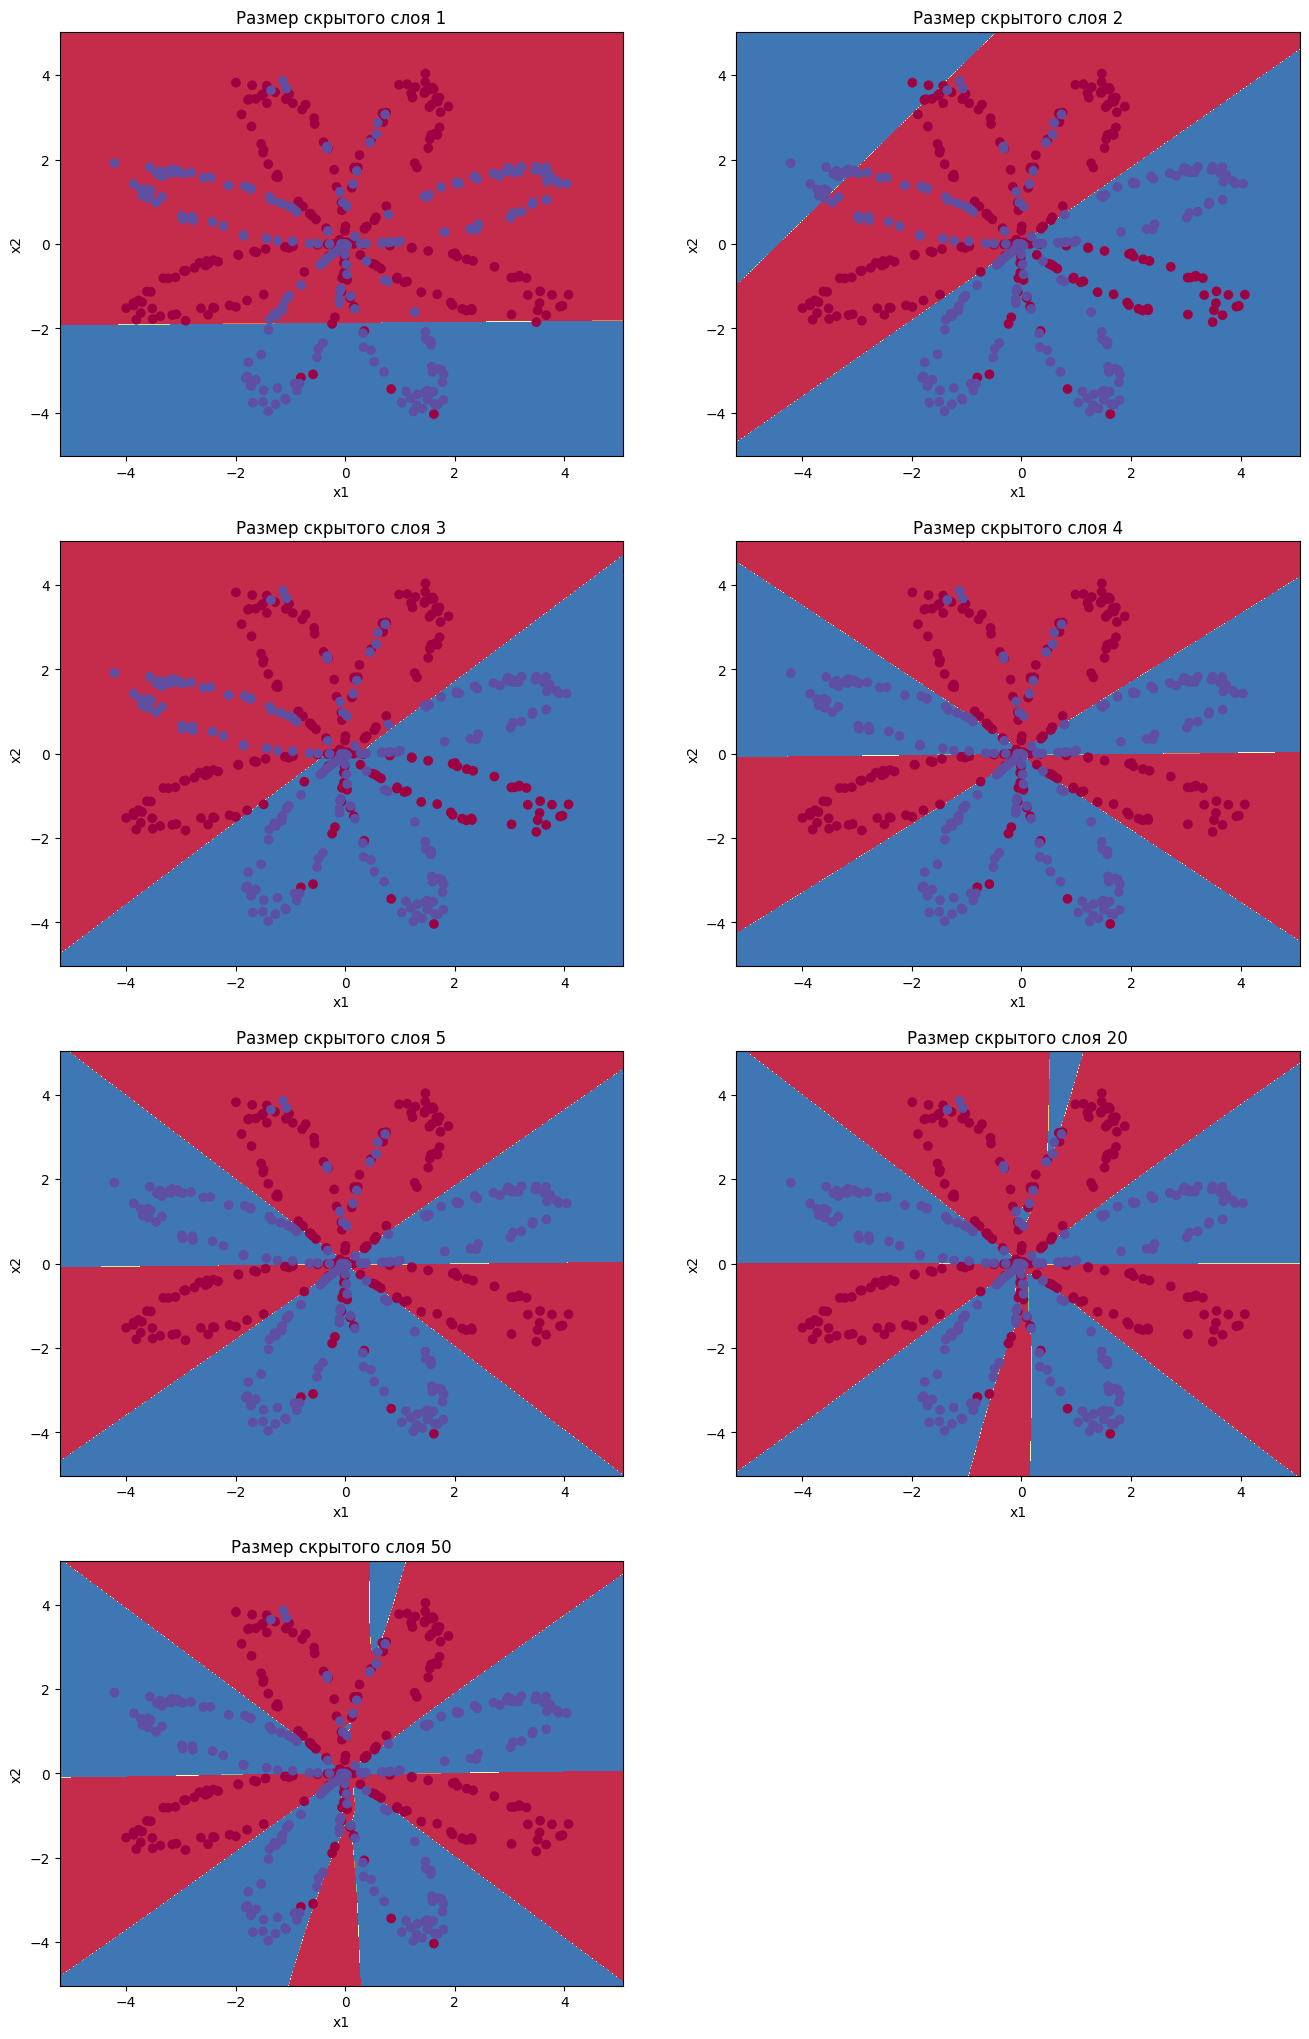

In [391]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Размер скрытого слоя %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Точность для {} скрытого слоя: {} %".format(n_h, accuracy))

**Объяснения**:
- Чем больше нейронов на скрытом слое, тем более точно модель описывает обучающую выборку, пока в какой-то момент максимально большая модель не переучится.
- Наиболее удачной будет модель с 5-ю нейронами на скрытом слое. При этом значении переобучение еще не происходит.
- Позже вы познакомитесь с понятием "регуляризация". Регуляризация позволяет использовать модели с большим количеством нейронов на скрытом слое без переобучения сети.

**Вопросы**:

- Что произойдет если изменить функцию активации с tanh на sigmoid или на ReLU?
- Проанализируйте на что влияет изменение learning_rate.
- Выберите датасет из раздела 5, согласно своему варианту.

learning rate: <br>
0.1–1.5 — быстро сходится; <br>
<0.05 — нужно много эпох, cost падает медленно;<br>
2 — возможны скачки cost,<br>

ReLu быстро сходится (очевидно из-за линейности), но будет работать хуже Sigmoid

## 5) Самостоятельная работа.
Выберите датасет согласно своему варианту. Обучите нейронную сеть и выполните классификацию. Постройте график ошибки на обучении, подберите наилучшую скорость обучения и количество эпох обучения. Сделайте выводы. Испробуте другие варианты архитектуры и функций активации на платформе http://playground.tensorflow.org/

In [416]:

from sklearn.datasets import make_moons

X_tmp, Y_tmp = make_moons(n_samples=5000, noise=0.2, random_state=0)
X2 = X_tmp.T
Y2 = Y_tmp.reshape(1, -1)


Значение ошибки после 0 итерации: 2.533336
Значение ошибки после 1000 итерации: 0.082029
Значение ошибки после 2000 итерации: 0.080141
Значение ошибки после 3000 итерации: 0.079117
Значение ошибки после 4000 итерации: 0.078472
Значение ошибки после 5000 итерации: 0.078061
Значение ошибки после 6000 итерации: 0.077795
Значение ошибки после 7000 итерации: 0.077616
Значение ошибки после 8000 итерации: 0.077488
Значение ошибки после 9000 итерации: 0.077390
Значение ошибки после 10000 итерации: 0.077310
Значение ошибки после 11000 итерации: 0.077243
Значение ошибки после 12000 итерации: 0.077183
Значение ошибки после 13000 итерации: 0.077130
Значение ошибки после 14000 итерации: 0.077082


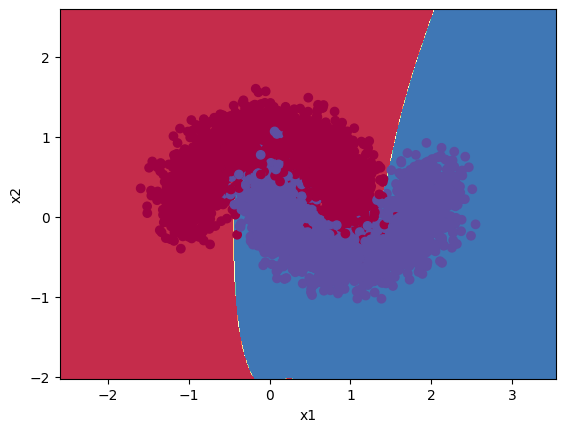

In [417]:

params = nn_model(X2, Y2, n_h=5,
                  num_iterations=15000,
                  print_cost=True)

plot_decision_boundary(lambda x: predict(params, x.T), X2, Y2)


YOUR ANSWER HERE

Контрольные вопросы:
1. Что входит в понятие архитектуры нейронной сети?
2. Какие параметры есть у нейронных сетей и как они могут быть инициализированы?
3. Что такое функционал стоимости? Для чего он нужен?
